In [1]:
%run ../config/initialize.ipynb

## Global functions

In [2]:
def get_window(window_type, n, partition_cols, date_orderby_col):
    '''accepts window type (days, games, seasons),
     size of window n,
     and window fields (partition and sort), 
     and returns a spark Window'''
    assert type(partition_cols) is list
    assert type(date_orderby_col) is str
    assert type(n) is int
    assert window_type in ['games','days','seasons']
    
    from pyspark.sql.window import Window
    if window_type == 'games':
        ## fixed number of games
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).desc())\
                  .rowsBetween(1, n)

    elif window_type == 'days':
        ## fixed number of days
        seconds = 24*60*60*n
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

    elif window_type == 'seasons':
        ## fixed number of seasons, including current
        ## n = 1 is YTD
        seconds = 24*60*60*(180 + 365*(n-1))
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

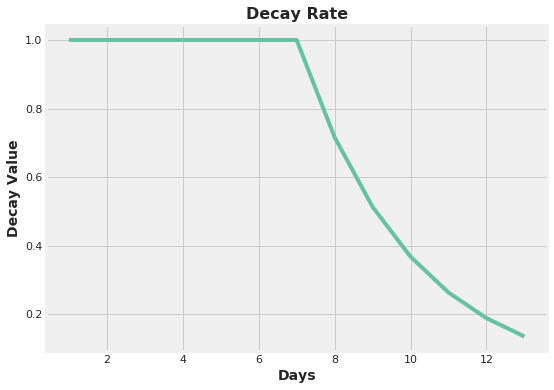

In [3]:
def decay_rate(x, offset, decay_rate, max_val):
    '''make a decay curve. offset keeps
    decay at 1 for that duration. max_val
    cuts off at 0.'''
    from math import exp
    if x <= offset:
        return 1.
    elif x >= max_val:
        return 0.
    else:
        return exp( (offset - float(x)) / decay_rate )
    
decay_rate_udf = udf(decay_rate, FloatType())
    
_ = pd.DataFrame.from_dict({i: decay_rate(i, 7, 3, 21)
     for i in np.arange(1, 14)}, orient='index')\
    .sort_index().plot(kind='line', title='Decay Rate', 
                       legend=None, figsize=(8,6))
_ = plt.xlabel('Days')
_ = plt.ylabel('Decay Value')

## Travel Features
* key: (game_id)
* table name: features.matchup
* __v_dist_from_home__
* __v_home_body_time__
* __h_days_since_last_game__
* __h_tz_change_last_game__
* __h_tz_change_last_10_days__
* __h_travel_from_last_game__
* __h_travel_from_last_10_days__
* __h_travel_from_last_game_decay__
* __h_same_stadium_last_game__
* __h_body_clock_from_last_wk__
* __v_days_since_last_game__
* __v_tz_change_last_game__
* __v_tz_change_last_10_days__
* __v_travel_from_last_game__
* __v_travel_from_last_10_days__
* __v_travel_from_last_game_decay__
* __v_same_stadium_last_game__
* __v_body_clock_from_last_wk__

In [4]:
key = 'game_id'
out_tbl = 'features.travel'
features_list = []

In [5]:
game = spark.table('game').select('game_id','season','date','week_id','stadium','h_team_id',
                                  'v_team_id','is_neutral')
stadium = spark.table('stadium').select('stadium','season','lat','long','timezone',
                                        'stadium_home_team')
game_tines = spark.table('game_metadata').select('game_id','game_time_eastern',
                                                 'game_time_local')

game_stad = game.join(stadium, on=['stadium','season'])\
                .join(game_tines, on=['game_id'])

game_stad.limit(5).toPandas()

,game_id,stadium,season,date,week_id,h_team_id,v_team_id,is_neutral,lat,long,timezone,stadium_home_team,game_time_eastern,game_time_local
0,201511150ram,Edward Jones Dome,2015,2015-11-15,10,ram,chi,0,38.63278,-90.18861,-6.0,['ram'],13.0,12.0
1,201511090sdg,Qualcomm Stadium,2015,2015-11-09,9,sdg,chi,0,32.78306,-117.11944,-8.0,['sdg'],21.0,18.0
2,201510180det,Ford Field,2015,2015-10-18,6,det,chi,0,42.34000,-83.04556,-5.0,['det'],13.0,13.0
3,201512270tam,Raymond James Stadium,2015,2015-12-27,16,tam,chi,0,27.97583,-82.50333,-5.0,['tam'],13.0,13.0
4,201510110kan,Arrowhead Stadium,2015,2015-10-11,5,kan,chi,0,39.04889,-94.48389,-6.0,['kan'],13.0,12.0


In [6]:
## join in with visitor's lat/long and timezone
visitor_home = game_stad.withColumn(
    'tmp', 
    ## python udf to convert string list to Spark Array
    udf(lambda x: eval(x), ArrayType(StringType()))('stadium_home_team')
).select(
    'stadium','season',
    col('lat').alias('v_lat'),
    col('long').alias('v_long'),
    col('timezone').alias('v_timezone'),
    F.explode('tmp').alias('v_team_id')
)

## dups exist, e.g. Bills play games in Toronto and I considered that
## their home stadium, so they have 2 home stadiums some season
visitor_home.groupby('v_team_id','season')\
    .agg(F.countDistinct('stadium').alias('count'))\
    .filter(col('count') > 1)\
    .toPandas()

visitor_count = visitor_home.groupby('v_team_id','season','stadium')\
                    .count()

visitor_max = visitor_count.groupby('v_team_id','season')\
                         .agg(F.max('count').alias('count'))

visitor_uniq = visitor_count.join(
    visitor_max, on=['v_team_id','season','count']
).drop('count')

assert visitor_uniq.groupby('v_team_id','season').count()\
        .toPandas()['count'].max() == 1

,v_team_id,season,count
0,buf,2009,2
1,buf,2013,2
2,min,2010,2
3,buf,2010,2
4,buf,2012,2
5,buf,2011,2
6,buf,2008,2


In [7]:
v_stad_info = visitor_uniq.join(
    spark.table('stadium').select(
        'stadium',
        'season',
        col('lat').alias('v_team_home_lat'),
        col('long').alias('v_team_home_long'),
        col('timezone').alias('v_team_tz'),
    ), on=['stadium','season']
).drop('stadium')

v_stad_info.limit(5).toPandas()

,season,v_team_id,v_team_home_lat,v_team_home_long,v_team_tz
0,2013,dal,32.74778,-97.09278,-6.0
1,2009,nyj,40.81222,-74.07694,-5.0
2,2013,sdg,32.78306,-117.11944,-8.0
3,2016,crd,33.52750,-112.26250,-7.0
4,2008,crd,33.52750,-112.26250,-7.0


In [8]:
game_stad_info = game_stad.select(
    'game_id','season','date','week_id','h_team_id','v_team_id','is_neutral',
    'game_time_eastern','game_time_local','stadium',
    col('lat').alias('h_lat'),
    col('long').alias('h_long'),
    col('timezone').alias('h_tz')
).join(
    v_stad_info, on=['v_team_id','season']
).select(
    'game_id','season','date','week_id','is_neutral','h_team_id','v_team_id',
    'h_lat', 'h_long', 'h_tz','v_team_home_lat','v_team_home_long','v_team_tz',
    'game_time_eastern','game_time_local','stadium'
).cache()

In [9]:
game_stad_info.limit(5).toPandas()

,game_id,season,date,week_id,is_neutral,h_team_id,v_team_id,h_lat,h_long,h_tz,v_team_home_lat,v_team_home_long,v_team_tz,game_time_eastern,game_time_local,stadium
0,201109250buf,2011,2011-09-25,3,0,buf,nwe,42.77400,-78.78700,-5.0,42.090944,-71.264344,-5.0,13.0,13.0,Ralph Wilson Stadium
1,201112110was,2011,2011-12-11,14,0,was,nwe,38.90778,-76.86444,-5.0,42.090944,-71.264344,-5.0,13.0,13.0,FedExField
2,201110300pit,2011,2011-10-30,8,0,pit,nwe,40.44667,-80.01583,-5.0,42.090944,-71.264344,-5.0,16.0,16.0,Heinz Field
3,201111270phi,2011,2011-11-27,12,0,phi,nwe,39.90083,-75.16750,-5.0,42.090944,-71.264344,-5.0,16.0,16.0,Lincoln Financial Field
4,201109120mia,2011,2011-09-12,1,0,mia,nwe,25.95806,-80.23889,-5.0,42.090944,-71.264344,-5.0,19.0,19.0,Sun Life Stadium


### Visitor's distance from home stadium

In [10]:
def spark_euclidean_dist(a_lat, b_lat, a_long, b_long):
    '''given column names of 2 pairs of lat/long, 
    return euclidean distance Spark formula'''
    return F.sqrt( 
            (col(a_lat) - col(b_lat))**2 
             + (col(a_long) - col(b_long))**2 
        )

feat_name = 'v_dist_from_home'

game_stad_info = game_stad_info.withColumn(
    feat_name, 
    spark_euclidean_dist('h_lat', 'v_team_home_lat',
                         'h_long','v_team_home_long')
)

features_list.append(feat_name)

### Body clock time: gametime relative to home timezone

In [11]:
feat_name = 'v_home_body_time'

game_stad_info = game_stad_info.withColumn(
    feat_name, 
    col('game_time_local') + col('v_team_tz') - col('h_tz')
)

features_list.append(feat_name)

game_stad_info.limit(5).toPandas()

,game_id,season,date,week_id,is_neutral,h_team_id,v_team_id,h_lat,h_long,h_tz,v_team_home_lat,v_team_home_long,v_team_tz,game_time_eastern,game_time_local,stadium,v_dist_from_home,v_home_body_time
0,201109250buf,2011,2011-09-25,3,0,buf,nwe,42.77400,-78.78700,-5.0,42.090944,-71.264344,-5.0,13.0,13.0,Ralph Wilson Stadium,7.553603,13.0
1,201112110was,2011,2011-12-11,14,0,was,nwe,38.90778,-76.86444,-5.0,42.090944,-71.264344,-5.0,13.0,13.0,FedExField,6.441553,13.0
2,201110300pit,2011,2011-10-30,8,0,pit,nwe,40.44667,-80.01583,-5.0,42.090944,-71.264344,-5.0,16.0,16.0,Heinz Field,8.904613,16.0
3,201111270phi,2011,2011-11-27,12,0,phi,nwe,39.90083,-75.16750,-5.0,42.090944,-71.264344,-5.0,16.0,16.0,Lincoln Financial Field,4.475626,16.0
4,201109120mia,2011,2011-09-12,1,0,mia,nwe,25.95806,-80.23889,-5.0,42.090944,-71.264344,-5.0,19.0,19.0,Sun Life Stadium,18.461106,19.0


#### For Travel from last game, create a new DF unique but (game_id, team_id)

In [12]:
h_v_feats = []

In [13]:
feat_name_gen = '{}_travel_from_last_wk'

game_stad_team = game_stad_info.withColumn(
        'tmp', F.array('h_team_id','v_team_id')
    ).select(
        '*', 
        F.explode('tmp').alias('team_id')
    ).select(
        'game_id','date','season','week_id','team_id',
        'game_time_local','game_time_eastern',
        'stadium',
        col('h_tz').alias('tz'),
        col('h_lat').alias('lat'),
        col('h_long').alias('lon'),
    )

In [14]:
feat_name = 'days_since_last_game'

w = get_window('games', 1, ['team_id','season'], 'date')

vs_last_wk = game_stad_team.withColumn(
        'prev_lat', F.sum(col('lat')).over(w)
    ).withColumn(
        'prev_lon', F.sum(col('lon')).over(w)
    ).withColumn(
        'prev_tz', F.sum(col('tz')).over(w)
    ).withColumn(
        'prev_stadium', F.max(col('stadium')).over(w)
    ).withColumn(
        feat_name, F.datediff(col('date'), F.max('date').over(w))
    )

h_v_feats.append(feat_name)

### Timezone change from {last game, game w/in last 10 days}
### Travel distance from {last game, game w/in last 10 days, decayed}
### Body clock time from last week

In [15]:
vs_last_wk_feats = vs_last_wk.withColumn(
        'tz_change_last_game', col('tz') - col('prev_tz')
    ).withColumn(
        'tz_change_last_10_days', 
        F.when(col('days_since_last_game') <= 10, col('tz_change_last_game'))
         .otherwise(0)
    ).withColumn(
        'travel_from_last_game', 
        spark_euclidean_dist('lat','prev_lat','lon','prev_lon')
    ).withColumn(
        'travel_from_last_10_days', 
        F.when(
            col('days_since_last_game') <= 10, col('travel_from_last_game')
        ).otherwise(0)
    ).withColumn(
        'travel_from_last_game_decay', 
        decay_rate_udf(col('days_since_last_game'), F.lit(7), F.lit(3), F.lit(21)) 
        * col('travel_from_last_game')
    ).withColumn(
        'same_stadium_last_game',
        F.when(col('stadium') == col('prev_stadium'), 1).otherwise(0)
    ).withColumn(
        'body_clock_from_last_wk',
        col('game_time_local') + col('prev_tz') - col('tz')
    )

h_v_feats += ['tz_change_last_game',
                'tz_change_last_10_days',
                'travel_from_last_game',
                'travel_from_last_10_days',
                'travel_from_last_game_decay',
                'same_stadium_last_game',
                'body_clock_from_last_wk']

prev_week_feats = vs_last_wk_feats.select(*(['game_id','team_id'] + h_v_feats))

In [16]:
prev_week_feats.limit(5).toPandas()

,game_id,team_id,days_since_last_game,tz_change_last_game,tz_change_last_10_days,travel_from_last_game,travel_from_last_10_days,travel_from_last_game_decay,same_stadium_last_game,body_clock_from_last_wk
0,201202050nwe,nwe,14,0.0,0.0,15.080683,0.000000,1.462403,0,19.0
1,201201220nwe,nwe,8,0.0,0.0,0.000000,0.000000,0.000000,1,15.0
2,201201140nwe,nwe,13,0.0,0.0,0.000000,0.000000,0.000000,1,20.0
3,201201010nwe,nwe,8,0.0,0.0,0.000000,0.000000,0.000000,1,13.0
4,201112240nwe,nwe,6,2.0,2.0,33.837153,33.837153,33.837153,0,11.0


#### Combine with (game, team_id table)

In [17]:
h_prev_week_feats = prev_week_feats.withColumnRenamed('team_id', 'h_team_id')
v_prev_week_feats = prev_week_feats.withColumnRenamed('team_id', 'v_team_id')

for f in h_v_feats:
    h_prev_week_feats = h_prev_week_feats.withColumnRenamed(f, 'h_{}'.format(f))
    v_prev_week_feats = v_prev_week_feats.withColumnRenamed(f, 'v_{}'.format(f))

travel_feats = game_stad_info.select(*(
    [key, 'h_team_id', 'v_team_id'] + features_list
)).join(
    h_prev_week_feats, on=['game_id','h_team_id']
).join(
    v_prev_week_feats, on=['game_id','v_team_id']
)

In [18]:
features_list += map(lambda x: 'h_{}'.format(x), h_v_feats)
features_list += map(lambda x: 'v_{}'.format(x), h_v_feats)

## Write Table

In [19]:
print '* __' + '__\n* __'.join(features_list) + '__'

* __v_dist_from_home__
* __v_home_body_time__
* __h_days_since_last_game__
* __h_tz_change_last_game__
* __h_tz_change_last_10_days__
* __h_travel_from_last_game__
* __h_travel_from_last_10_days__
* __h_travel_from_last_game_decay__
* __h_same_stadium_last_game__
* __h_body_clock_from_last_wk__
* __v_days_since_last_game__
* __v_tz_change_last_game__
* __v_tz_change_last_10_days__
* __v_travel_from_last_game__
* __v_travel_from_last_10_days__
* __v_travel_from_last_game_decay__
* __v_same_stadium_last_game__
* __v_body_clock_from_last_wk__


In [20]:
travel_feats.select(*([key] + features_list))\
        .write.mode('overwrite').saveAsTable(out_tbl)

In [21]:
spark.table(out_tbl).limit(5).toPandas()

,game_id,v_dist_from_home,v_home_body_time,h_days_since_last_game,h_tz_change_last_game,h_tz_change_last_10_days,h_travel_from_last_game,h_travel_from_last_10_days,h_travel_from_last_game_decay,h_same_stadium_last_game,h_body_clock_from_last_wk,v_days_since_last_game,v_tz_change_last_game,v_tz_change_last_10_days,v_travel_from_last_game,v_travel_from_last_10_days,v_travel_from_last_game_decay,v_same_stadium_last_game,v_body_clock_from_last_wk
0,200902010crd,12.716505,19.0,14,2.0,0.0,30.272582,0.000000,2.935592,0,17.0,14,0.0,0.0,12.716505,0.000000,1.233145,0,19.0
1,200901180crd,37.638522,16.0,8,-2.0,-2.0,31.455601,31.455601,22.538924,0,16.0,7,-2.0,-2.0,38.874209,38.874209,38.874209,0,16.0
2,200901030crd,27.862453,17.0,6,0.0,0.0,0.000000,0.000000,0.000000,1,15.0,6,-2.0,-2.0,27.862453,27.862453,27.862453,0,17.0
3,200812280crd,17.299912,13.0,7,-2.0,-2.0,41.882948,41.882948,41.882948,0,16.0,7,1.0,1.0,17.299912,17.299912,17.299912,0,13.0
4,200812140crd,22.185324,15.0,7,0.0,0.0,0.000000,0.000000,0.000000,1,14.0,7,-2.0,-2.0,30.517040,30.517040,30.517040,0,16.0
